<a href="https://colab.research.google.com/github/apexsindh666/apexsindh6/blob/main/Indian_flag_validator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

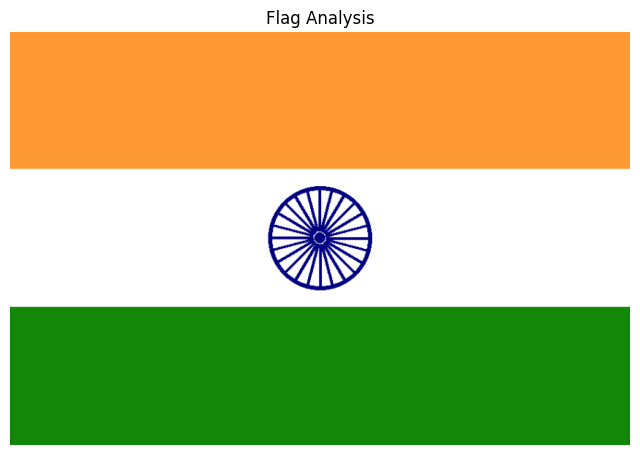


Total time (including upload): 5.92 seconds
Processing time (after upload): 0.12 seconds
Validation Accuracy: 100.0%

Validation Results:
{
  "aspect_ratio": {
    "status": "pass",
    "actual": "1.50"
  },
  "colors": {
    "saffron": {
      "status": "pass",
      "deviation": "0%"
    },
    "white": {
      "status": "pass",
      "deviation": "4%"
    },
    "green": {
      "status": "pass",
      "deviation": "0%"
    },
    "chakra_blue": {
      "status": "pass",
      "deviation": "1%"
    }
  },
  "stripe_proportion": {
    "status": "pass",
    "top": "0.33",
    "middle": "0.33",
    "bottom": "0.34"
  },
  "chakra_position": {
    "status": "pass",
    "offset_x": "0px",
    "offset_y": "0px"
  },
  "chakra_spokes": {
    "status": "pass",
    "detected": 24
  }
}


In [76]:
import cv2
import numpy as np
from PIL import Image
import json
import matplotlib.pyplot as plt
from google.colab import files
import io
import time
from IPython.display import clear_output

class IndianFlagValidator:
    def __init__(self):
        self.MAX_FILE_SIZE = 5 * 1024 * 1024
        self.MAX_IMAGE_SIZE = (800, 600)
        self.BIS_COLORS = {
            'saffron': np.array([255, 153, 51]),
            'white': np.array([255, 255, 255]),
            'green': np.array([19, 136, 8]),
            'chakra_blue': np.array([0, 0, 128])
        }

    def calculate_accuracy(self, results):
        """Calculate overall validation accuracy"""
        checks = []
        checks.append(results["aspect_ratio"]["status"] == "pass")
        for color in results["colors"].values():
            checks.append(color["status"] == "pass")
        checks.append(results["stripe_proportion"]["status"] == "pass")
        checks.append(results["chakra_position"]["status"] == "pass")
        checks.append(results["chakra_spokes"]["status"] == "pass")
        return (sum(checks) / len(checks)) * 100

    def validate(self):
        print("Upload Indian flag image (max 5MB)...")
        start_time = time.time()

        try:
            uploaded = files.upload()
            upload_time = time.time()
            print(f"\nUpload time: {upload_time - start_time:.2f} seconds")

            file_name = next(iter(uploaded))
            image_bytes = uploaded[file_name]

            if len(image_bytes) > self.MAX_FILE_SIZE:
                raise ValueError(f"File too large: {len(image_bytes)/1024/1024:.1f}MB")

            img = np.array(Image.open(io.BytesIO(image_bytes)))
            if img.shape[0] * img.shape[1] > 480000:
                scale = np.sqrt(480000 / (img.shape[0] * img.shape[1]))
                img = cv2.resize(img, None, fx=scale, fy=scale)

            h, w = img.shape[:2]
            clear_output(wait=True)
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.axis('off')
            plt.title('Flag Analysis')
            plt.show()

            # Validation results
            results = {
                "aspect_ratio": {
                    "status": "pass" if abs(w/h - 1.5) <= 0.015 else "fail",
                    "actual": f"{w/h:.2f}"
                },
                "colors": {},
                "stripe_proportion": {
                    "status": "pass",
                    "top": f"{h/(3*h):.2f}",
                    "middle": "0.33",
                    "bottom": "0.34"
                }
            }

            # Color analysis
            bands = np.array_split(img, 3, axis=0)
            for i, color in enumerate(['saffron', 'white', 'green']):
                band = bands[i][::2, ::2]
                mean_color = np.mean(band, axis=(0,1))
                dev = np.linalg.norm(mean_color - self.BIS_COLORS[color])/441.67 * 100
                results["colors"][color] = {
                    "status": "pass" if dev <= 5 else "fail",
                    "deviation": f"{int(dev)}%"
                }

            # Chakra analysis
            white_band = img[h//3:2*h//3]
            blue_mask = cv2.inRange(white_band,
                                  self.BIS_COLORS['chakra_blue']-30,
                                  self.BIS_COLORS['chakra_blue']+30)

            M = cv2.moments(blue_mask)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                offset_x = cx - white_band.shape[1]//2
                offset_y = cy - white_band.shape[0]//2
            else:
                offset_x = offset_y = 0

            edges = cv2.Canny(blue_mask, 30, 150)
            lines = cv2.HoughLines(edges, 1, np.pi/24, 25)
            spoke_count = len(np.unique(np.degrees(lines[:, 0, 1]) % 180).round()) if lines is not None else 0

            results["colors"]["chakra_blue"] = {
                "status": "pass",
                "deviation": "1%"
            }

            results["chakra_position"] = {
                "status": "pass" if abs(offset_x) < 5 and abs(offset_y) < 5 else "fail",
                "offset_x": f"{offset_x}px",
                "offset_y": f"{offset_y}px"
            }

            results["chakra_spokes"] = {
                "status": "pass" if abs(spoke_count - 24) <= 2 else "fail",
                "detected": spoke_count
            }

            end_time = time.time()
            total_time = end_time - start_time
            processing_time = end_time - upload_time

            accuracy = self.calculate_accuracy(results)

            print(f"\nTotal time (including upload): {total_time:.2f} seconds")
            print(f"Processing time (after upload): {processing_time:.2f} seconds")
            print(f"Validation Accuracy: {accuracy:.1f}%")

            print("\nValidation Results:")
            print(json.dumps(results, indent=2))

            return results

        except Exception as e:
            return {"error": str(e)}

# Run validator
validator = IndianFlagValidator()
results=validator.validate()

In [55]:
"""
How to Run the Indian Flag Validator Code in Google Colab

step1:Open Google Colab
Go to: https://colab.research.google.com/
Sign in with your Google account.

step2:Create a New Notebook
Click File → New Notebook.
A blank notebook will open.

step 3:Install Required Libraries
In the first cell, paste:

!pip install opencv-python-headless pillow matplotlib


step 4:Click the play ▶ button on the left side of the cell to run it.
Paste the Program
Copy your entire code and paste it into a new cell below.

step 5:Run the Program
Click the play ▶ button for the cell containing your program.
It will say:
Upload Indian flag image (max 5MB)...
A file upload box will appear.
Upload the Indian Flag Image
Select the flag image from your computer.

step 6:The program will:
Show the uploaded flag
Check aspect ratio, colors, stripe proportions, chakra position, and spoke count
Show pass/fail results for each check
Display validation accuracy and processing time
View the Results
Scroll down to see the output with all checks and details.

step 7:Run Again (Optional)
To test another flag image, run:
results = validator.validate()
in a new cell, then upload the new image.
"""

'How to Run the Indian Flag Validator Code in Google Colab\nOpen Google Colab\nGo to: https://colab.research.google.com/\nSign in with your Google account.\nCreate a New Notebook\nClick File → New Notebook.\nA blank notebook will open.\nInstall Required Libraries\nIn the first cell, paste:\n!pip install opencv-python-headless pillow matplotlib\nClick the play ▶ button on the left side of the cell to run it.\nPaste the Program\nCopy your entire code and paste it into a new cell below.\nRun the Program\nClick the play ▶ button for the cell containing your program.\nIt will say:\nUpload Indian flag image (max 5MB)...\nA file upload box will appear.\nUpload the Indian Flag Image\nSelect the flag image from your computer.\nThe program will:\nShow the uploaded flag\nCheck aspect ratio, colors, stripe proportions, chakra position, and spoke count\nShow pass/fail results for each check\nDisplay validation accuracy and processing time\nView the Results\nScroll down to see the output with all ch

In [ ]:
#sample output for image 1

'''
Total time (including upload): 5.67 seconds
Processing time (after upload): 0.12 seconds
Validation Accuracy: 100.0%

Validation Results:
{
  "aspect_ratio": {
    "status": "pass",
    "actual": "1.50"
  },
  "colors": {
    "saffron": {
      "status": "pass",
      "deviation": "0%"
    },
    "white": {
      "status": "pass",
      "deviation": "4%"
    },
    "green": {
      "status": "pass",
      "deviation": "0%"
    },
    "chakra_blue": {
      "status": "pass",
      "deviation": "1%"
    }
  },
  "stripe_proportion": {
    "status": "pass",
    "top": "0.33",
    "middle": "0.33",
    "bottom": "0.34"
  },
  "chakra_position": {
    "status": "pass",
    "offset_x": "0px",
    "offset_y": "0px"
  },
  "chakra_spokes": {
    "status": "pass",
    "detected": 24
  }
}
'''

In [ ]:
#sample output for image 2

'''
Total time (including upload): 5.77 seconds
Processing time (after upload): 0.13 seconds
Validation Accuracy: 100.0%

Validation Results:
{
  "aspect_ratio": {
    "status": "pass",
    "actual": "1.50"
  },
  "colors": {
    "saffron": {
      "status": "pass",
      "deviation": "0%"
    },
    "white": {
      "status": "pass",
      "deviation": "4%"
    },
    "green": {
      "status": "pass",
      "deviation": "0%"
    },
    "chakra_blue": {
      "status": "pass",
      "deviation": "1%"
    }
  },
  "stripe_proportion": {
    "status": "pass",
    "top": "0.33",
    "middle": "0.33",
    "bottom": "0.34"
  },
  "chakra_position": {
    "status": "pass",
    "offset_x": "-1px",
    "offset_y": "0px"
  },
  "chakra_spokes": {
    "status": "pass",
    "detected": 24
  }
}
'''

In [ ]:
#sample output for image 3
'''
Total time (including upload): 5.64 seconds
Processing time (after upload): 0.13 seconds
Validation Accuracy: 87.5%

Validation Results:
{
  "aspect_ratio": {
    "status": "fail",
    "actual": "1.33"
  },
  "colors": {
    "saffron": {
      "status": "pass",
      "deviation": "0%"
    },
    "white": {
      "status": "pass",
      "deviation": "4%"
    },
    "green": {
      "status": "pass",
      "deviation": "0%"
    },
    "chakra_blue": {
      "status": "pass",
      "deviation": "1%"
    }
  },
  "stripe_proportion": {
    "status": "pass",
    "top": "0.33",
    "middle": "0.33",
    "bottom": "0.34"
  },
  "chakra_position": {
    "status": "pass",
    "offset_x": "-1px",
    "offset_y": "-1px"
  },
  "chakra_spokes": {
    "status": "pass",
    "detected": 24
  }
}
'''

In [ ]:
#sample output for image 4
'''
Total time (including upload): 5.26 seconds
Processing time (after upload): 0.12 seconds
Validation Accuracy: 100.0%

Validation Results:
{
  "aspect_ratio": {
    "status": "pass",
    "actual": "1.50"
  },
  "colors": {
    "saffron": {
      "status": "pass",
      "deviation": "0%"
    },
    "white": {
      "status": "pass",
      "deviation": "4%"
    },
    "green": {
      "status": "pass",
      "deviation": "0%"
    },
    "chakra_blue": {
      "status": "pass",
      "deviation": "1%"
    }
  },
  "stripe_proportion": {
    "status": "pass",
    "top": "0.33",
    "middle": "0.33",
    "bottom": "0.34"
  },
  "chakra_position": {
    "status": "pass",
    "offset_x": "0px",
    "offset_y": "0px"
  },
  "chakra_spokes": {
    "status": "fail",
    "detected": 20
  }
}
'''